# CycleGAN Exercise

In this notebook we will implement the CycleGAN loss from the original [paper](https://arxiv.org/pdf/1703.10593.pdf). Let us spend a moment appreciating the utter passion which had driven authors toward this solution, by reading their thoughts on the Monet artistic process:

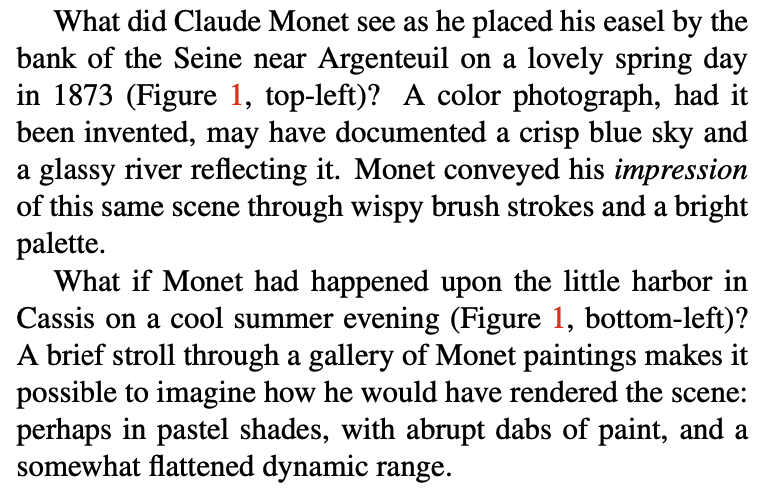

In this exercise we will implement the Cycle GAN loss. Now, please spend a few minutes on reading the [paper](https://arxiv.org/pdf/1703.10593.pdf), and understanding each piece of the Cycle GAN loss, before coming back to the implementation.

Now let us begin the implementation.

First - please download the data from [here](https://drive.google.com/file/d/1-3-u9l5qcUcIkdBuztqEAeZA8p_QEFcN/view?usp=share_link). Unzip it to a directory of your choice and set the `root` variable to a directory where you unzipped the file.

In [ ]:
import os

import numpy as np

from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms


from tqdm.notebook import tqdm
import warnings

n_cpu = 2
root = 'MONET-IMAGES' # Set it to a directory where you unpacked the data provided for the exercise.

Now - let us set some constants needed for the training process:

In [ ]:
# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs = 5 # number of epochs of training
batch_size = 1 # size of the batches

# Optimizer
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

### Task 1: Implement the Residual Block for the task.

It should accept `in_features` and perform the following operations:

1. First Convolution,
2. Instance norm,
3. Activation (ReLU recommended),
4. Second convolution
5. Instance norm,
6. Adding the output of the step 5 to the input.

All convolutions should have the same `in_features` number of filters. They should also have a reflection padding.

In [ ]:
class ResidualBlock(nn.Module):
    #TODO:

Now we will use this block to build the generator and discriminator networks.

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]

        # Unpacking
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

**NOTE:** This is a *patch* discriminator:

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

Now let us define few networks and criterions:

CRITERIONS:
- `criterion_GAN` that is used for a discriminator training
- `criterion_cycle` that is used for a cycle training
- `criterion_identity` that is used for an identity training

NETWORKS:
- `G_MonetToReal` - that is used to transfer Monet images to Real images
- `G_RealToMonet` - that is used to transfer Real images to Monet
- `D_Monet` - discriminator for `G_MonetToReal`
- `D_Real` - discriminator for `G_RealToMonet`

In [ ]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_MonetToReal = GeneratorResNet(input_shape, n_residual_blocks)
G_RealToMonet = GeneratorResNet(input_shape, n_residual_blocks)
D_Monet = Discriminator(input_shape)
D_Real = Discriminator(input_shape)

In [ ]:
cuda = torch.cuda.is_available()

if cuda:
    G_MonetToReal = G_MonetToReal.cuda()
    G_RealToMonet = G_RealToMonet.cuda()
    D_Monet = D_Monet.cuda()
    D_Real = D_Real.cuda()

    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

Now let us implement the optimizers:

In [ ]:
import itertools

optimizer_G = torch.optim.Adam(
    itertools.chain(G_MonetToReal.parameters(), G_RealToMonet.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_Monet = torch.optim.Adam(
    D_Monet.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_Real = torch.optim.Adam(
    D_Real.parameters(), lr=lr, betas=(b1,b2)
)

... and custom `LambdaLR` schedule from the paper:

In [ ]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_Monet = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_Monet,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_Real = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_Real,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

Now, let us jump through some useful, image preprocessing related tools:

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

In [ ]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [ ]:
import os
import glob

In [ ]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*'))
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*'))
        elif self.mode == 'test':
            print(len(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')))
            print(len(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')))
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[45:])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[45:])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'Monet':item_A, 'Real':item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [ ]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=n_cpu # 3
)


val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=n_cpu
)

In [ ]:
import matplotlib.pyplot as plt


Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor


def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_MonetToReal.eval()
    G_RealToMonet.eval()
    real_A = imgs['Monet'].type(Tensor)
    fake_B = G_MonetToReal(real_A).detach()
    real_B = imgs['Real'].type(Tensor)
    fake_A = G_RealToMonet(real_B).detach()

    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

Now - implement the appropriate losses and optimizer steps. Remember to update only specific parameters in each step:

**NOTE:** what one might expect from the training? Well - this dataset is relatively small, but with a good block architecture (and potential cycle loss / gan / identitiy loss reweighting) - you should get a nice, *Monet-like* images.

In [ ]:
CYCLE_LOSS_WEIGHT = 5.0
IDENTITY_LOSS_WEIGHT = 10.0

for epoch in range(epoch, 50):
    for i, batch in enumerate(tqdm(dataloader)):

        # Set model input
        real_A = batch['Monet'].type(Tensor)
        real_B = batch['Real'].type(Tensor)

        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_Monet.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_Monet.output_shape))) # requires_grad = False. Default.

# -----------------
# Train Generators
# -----------------
        G_MonetToReal.train()
        G_RealToMonet.train()

        optimizer_G.zero_grad()

        # Identity Loss
        loss_identity = None # TODO

        # GAN Loss
        loss_GAN = None # TODO

        # Cycle Loss

        loss_cycle = None # TODO

# ------> Total Loss
        loss_G = loss_GAN + (CYCLE_LOSS_WEIGHT * loss_cycle) + (IDENTITY_LOSS_WEIGHT * loss_identity)

        loss_G.backward()
        optimizer_G.step()

# -----------------
# Train Discriminator A
# -----------------
        loss_D_Monet = None # TODO

        loss_D_Monet.backward()
        optimizer_D_Monet.step()

# -----------------
# Train Discriminator B
# -----------------
        loss_D_Real = None # TODO

        loss_D_Real.backward()
        optimizer_D_Real.step()

# ------> Total Loss
        loss_D = (loss_D_Real + loss_D_Monet)/2

# -----------------
# Show Progress
# -----------------
        if (i+1) % 20 == 0:
            sample_images()
            print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_D.item(),       # [D loss -]
                      loss_G.item(),       # [G loss -]
                      loss_GAN.item(),     # [adv -]
                      loss_cycle.item(),   # [cycle -]
                      loss_identity.item(),# [identity -]
                     ))